# Import packages

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=1)

import os
import time
import copy
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datetime import timedelta
from ipynb.fs.defs.research import to_tensor, normalise, reshape_tsr, CryptoImageDataset, \
ModelSaver, EarlyStoppingValidator, ModelTrainerTester, plot_learning_curves, plot_conf_matx,\
CNNGRU, CNN, GRU, ExecutionHandler

In [2]:
RANDOM_SEED = 11919925
BATCH_SIZE = 256
LR = 1e-3
TIMEPERIOD = 30
NUM_LOOPS = 30
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

TRAIN_CUTOFF = pd.to_datetime("2021-07-01 00:00:00+00:00")
VAL_CUTOFF = pd.to_datetime("2023-01-01 00:00:00+00:00")

In [3]:
btc = pd.read_feather('./datasets/BTC_USDT-1h-new.feather')
eth = pd.read_feather('./datasets/ETH_USDT-1h-new.feather')
bnb = pd.read_feather('./datasets/BNB_USDT-1h-new.feather')

# BTC Dataset

## Open statistics files

In [4]:
with open('./statistics/BTC_CNNGRU_allstats.json') as f:
    BTC_CNNGRU_allstats = json.load(f)

with open('./statistics/BTC_CNN_allstats.json') as f:
    BTC_CNN_allstats = json.load(f)
    
with open('./statistics/BTC_GRU_allstats.json') as f:
    BTC_GRU_allstats = json.load(f)

## Reporting

### Creating lists

In [5]:
BTC_CNNGRU_test_precision = []
BTC_CNNGRU_test_recall = []
BTC_CNNGRU_test_f1_score = []
for i in range(NUM_LOOPS):
    BTC_CNNGRU_test_precision.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["avg_macro"]["test"]["precision"])
    BTC_CNNGRU_test_recall.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["avg_macro"]["test"]["recall"])
    BTC_CNNGRU_test_f1_score.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["avg_macro"]["test"]["f1_score"])

In [6]:
BTC_CNN_test_precision = []
BTC_CNN_test_recall = []
BTC_CNN_test_f1_score = []
for i in range(NUM_LOOPS):
    BTC_CNN_test_precision.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["avg_macro"]["test"]["precision"])
    BTC_CNN_test_recall.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["avg_macro"]["test"]["recall"])
    BTC_CNN_test_f1_score.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["avg_macro"]["test"]["f1_score"])

In [7]:
BTC_GRU_test_precision = []
BTC_GRU_test_recall = []
BTC_GRU_test_f1_score = []
for i in range(NUM_LOOPS):
    BTC_GRU_test_precision.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["avg_macro"]["test"]["precision"])
    BTC_GRU_test_recall.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["avg_macro"]["test"]["recall"])
    BTC_GRU_test_f1_score.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["avg_macro"]["test"]["f1_score"])

### To Numpy arrays for per-class calculations

In [8]:
BTC_CNNGRU_test_precision_perclass = np.empty((0,3))
BTC_CNNGRU_test_recall_perclass = np.empty((0,3))
BTC_CNNGRU_test_f1_score_perclass = np.empty((0,3))
BTC_CNNGRU_test_support_perclass = np.empty((0,3))


for i in range(NUM_LOOPS):
    BTC_CNNGRU_test_precision_perclass = np.append(BTC_CNNGRU_test_precision_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BTC_CNNGRU_test_recall_perclass = np.append(BTC_CNNGRU_test_recall_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BTC_CNNGRU_test_f1_score_perclass = np.append(BTC_CNNGRU_test_f1_score_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BTC_CNNGRU_test_support_perclass = np.append(BTC_CNNGRU_test_support_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

In [9]:
BTC_CNN_test_precision_perclass = np.empty((0,3))
BTC_CNN_test_recall_perclass = np.empty((0,3))
BTC_CNN_test_f1_score_perclass = np.empty((0,3))
BTC_CNN_test_support_perclass = np.empty((0,3))


for i in range(NUM_LOOPS):
    BTC_CNN_test_precision_perclass = np.append(BTC_CNN_test_precision_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BTC_CNN_test_recall_perclass = np.append(BTC_CNN_test_recall_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BTC_CNN_test_f1_score_perclass = np.append(BTC_CNN_test_f1_score_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BTC_CNN_test_support_perclass = np.append(BTC_CNN_test_support_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

In [10]:
BTC_GRU_test_precision_perclass = np.empty((0,3))
BTC_GRU_test_recall_perclass = np.empty((0,3))
BTC_GRU_test_f1_score_perclass = np.empty((0,3))
BTC_GRU_test_support_perclass = np.empty((0,3))


for i in range(NUM_LOOPS):
    BTC_GRU_test_precision_perclass = np.append(BTC_GRU_test_precision_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BTC_GRU_test_recall_perclass = np.append(BTC_GRU_test_recall_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BTC_GRU_test_f1_score_perclass = np.append(BTC_GRU_test_f1_score_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BTC_GRU_test_support_perclass = np.append(BTC_GRU_test_support_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

In [11]:
def print_stats_per_class(arr):
    """
    Convenience helper function to print statistics per class.
    """
    print(np.mean(arr, axis=0))
    print(np.var(arr, axis=0))
    print(np.min(arr, axis=0))
    print(np.median(arr, axis=0))
    print(np.max(arr, axis=0))
    

def print_stats(lst):
    arr = np.array(lst)
    print(np.mean(arr))
    print(np.var(arr))
    print(np.min(arr))
    print(np.median(arr))
    print(np.max(arr))

# ETH Dataset

## Open statistics files

In [12]:
with open('./statistics/ETH_CNNGRU_allstats.json') as f:
    ETH_CNNGRU_allstats = json.load(f)

with open('./statistics/ETH_CNN_allstats.json') as f:
    ETH_CNN_allstats = json.load(f)
    
with open('./statistics/ETH_GRU_allstats.json') as f:
    ETH_GRU_allstats = json.load(f)

## Reporting

### Creating lists

In [13]:
ETH_CNNGRU_test_precision = []
ETH_CNNGRU_test_recall = []
ETH_CNNGRU_test_f1_score = []
for i in range(NUM_LOOPS):
    ETH_CNNGRU_test_precision.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["avg_macro"]["test"]["precision"])
    ETH_CNNGRU_test_recall.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["avg_macro"]["test"]["recall"])
    ETH_CNNGRU_test_f1_score.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["avg_macro"]["test"]["f1_score"])

In [14]:
ETH_CNN_test_precision = []
ETH_CNN_test_recall = []
ETH_CNN_test_f1_score = []
for i in range(NUM_LOOPS):
    ETH_CNN_test_precision.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["avg_macro"]["test"]["precision"])
    ETH_CNN_test_recall.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["avg_macro"]["test"]["recall"])
    ETH_CNN_test_f1_score.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["avg_macro"]["test"]["f1_score"])

In [15]:
ETH_GRU_test_precision = []
ETH_GRU_test_recall = []
ETH_GRU_test_f1_score = []
for i in range(NUM_LOOPS):
    ETH_GRU_test_precision.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["avg_macro"]["test"]["precision"])
    ETH_GRU_test_recall.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["avg_macro"]["test"]["recall"])
    ETH_GRU_test_f1_score.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["avg_macro"]["test"]["f1_score"])

### To Numpy arrays for per-class calculations

In [16]:
# CNN-GRU
ETH_CNNGRU_test_precision_perclass = np.empty((0,3))
ETH_CNNGRU_test_recall_perclass = np.empty((0,3))
ETH_CNNGRU_test_f1_score_perclass = np.empty((0,3))
ETH_CNNGRU_test_support_perclass = np.empty((0,3))
for i in range(NUM_LOOPS):
    ETH_CNNGRU_test_precision_perclass = np.append(ETH_CNNGRU_test_precision_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    ETH_CNNGRU_test_recall_perclass = np.append(ETH_CNNGRU_test_recall_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    ETH_CNNGRU_test_f1_score_perclass = np.append(ETH_CNNGRU_test_f1_score_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    ETH_CNNGRU_test_support_perclass = np.append(ETH_CNNGRU_test_support_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

# CNN
ETH_CNN_test_precision_perclass = np.empty((0,3))
ETH_CNN_test_recall_perclass = np.empty((0,3))
ETH_CNN_test_f1_score_perclass = np.empty((0,3))
ETH_CNN_test_support_perclass = np.empty((0,3))
for i in range(NUM_LOOPS):
    ETH_CNN_test_precision_perclass = np.append(ETH_CNN_test_precision_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    ETH_CNN_test_recall_perclass = np.append(ETH_CNN_test_recall_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    ETH_CNN_test_f1_score_perclass = np.append(ETH_CNN_test_f1_score_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    ETH_CNN_test_support_perclass = np.append(ETH_CNN_test_support_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    
# GRU
ETH_GRU_test_precision_perclass = np.empty((0,3))
ETH_GRU_test_recall_perclass = np.empty((0,3))
ETH_GRU_test_f1_score_perclass = np.empty((0,3))
ETH_GRU_test_support_perclass = np.empty((0,3))
for i in range(NUM_LOOPS):
    ETH_GRU_test_precision_perclass = np.append(ETH_GRU_test_precision_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    ETH_GRU_test_recall_perclass = np.append(ETH_GRU_test_recall_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    ETH_GRU_test_f1_score_perclass = np.append(ETH_GRU_test_f1_score_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    ETH_GRU_test_support_perclass = np.append(ETH_GRU_test_support_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

# BNB Dataset

## Open statistics files

In [17]:
with open('./statistics/BNB_CNNGRU_allstats.json') as f:
    BNB_CNNGRU_allstats = json.load(f)

with open('./statistics/BNB_CNN_allstats.json') as f:
    BNB_CNN_allstats = json.load(f)
    
with open('./statistics/BNB_GRU_allstats.json') as f:
    BNB_GRU_allstats = json.load(f)

## Reporting

### Creating lists

In [18]:
BNB_CNNGRU_test_precision = []
BNB_CNNGRU_test_recall = []
BNB_CNNGRU_test_f1_score = []
for i in range(NUM_LOOPS):
    BNB_CNNGRU_test_precision.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["avg_macro"]["test"]["precision"])
    BNB_CNNGRU_test_recall.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["avg_macro"]["test"]["recall"])
    BNB_CNNGRU_test_f1_score.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    
BNB_CNN_test_precision = []
BNB_CNN_test_recall = []
BNB_CNN_test_f1_score = []
for i in range(NUM_LOOPS):
    BNB_CNN_test_precision.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["avg_macro"]["test"]["precision"])
    BNB_CNN_test_recall.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["avg_macro"]["test"]["recall"])
    BNB_CNN_test_f1_score.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    
BNB_GRU_test_precision = []
BNB_GRU_test_recall = []
BNB_GRU_test_f1_score = []
for i in range(NUM_LOOPS):
    BNB_GRU_test_precision.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["avg_macro"]["test"]["precision"])
    BNB_GRU_test_recall.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["avg_macro"]["test"]["recall"])
    BNB_GRU_test_f1_score.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["avg_macro"]["test"]["f1_score"])

### To Numpy arrays for per-class calculations

In [19]:
# CNN-GRU
BNB_CNNGRU_test_precision_perclass = np.empty((0,3))
BNB_CNNGRU_test_recall_perclass = np.empty((0,3))
BNB_CNNGRU_test_f1_score_perclass = np.empty((0,3))
BNB_CNNGRU_test_support_perclass = np.empty((0,3))
for i in range(NUM_LOOPS):
    BNB_CNNGRU_test_precision_perclass = np.append(BNB_CNNGRU_test_precision_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BNB_CNNGRU_test_recall_perclass = np.append(BNB_CNNGRU_test_recall_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BNB_CNNGRU_test_f1_score_perclass = np.append(BNB_CNNGRU_test_f1_score_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BNB_CNNGRU_test_support_perclass = np.append(BNB_CNNGRU_test_support_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

# CNN
BNB_CNN_test_precision_perclass = np.empty((0,3))
BNB_CNN_test_recall_perclass = np.empty((0,3))
BNB_CNN_test_f1_score_perclass = np.empty((0,3))
BNB_CNN_test_support_perclass = np.empty((0,3))
for i in range(NUM_LOOPS):
    BNB_CNN_test_precision_perclass = np.append(BNB_CNN_test_precision_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BNB_CNN_test_recall_perclass = np.append(BNB_CNN_test_recall_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BNB_CNN_test_f1_score_perclass = np.append(BNB_CNN_test_f1_score_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BNB_CNN_test_support_perclass = np.append(BNB_CNN_test_support_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    
# GRU
BNB_GRU_test_precision_perclass = np.empty((0,3))
BNB_GRU_test_recall_perclass = np.empty((0,3))
BNB_GRU_test_f1_score_perclass = np.empty((0,3))
BNB_GRU_test_support_perclass = np.empty((0,3))
for i in range(NUM_LOOPS):
    BNB_GRU_test_precision_perclass = np.append(BNB_GRU_test_precision_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BNB_GRU_test_recall_perclass = np.append(BNB_GRU_test_recall_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BNB_GRU_test_f1_score_perclass = np.append(BNB_GRU_test_f1_score_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BNB_GRU_test_support_perclass = np.append(BNB_GRU_test_support_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

In [20]:
print_stats_per_class(BNB_GRU_test_f1_score_perclass)

[0.76862048 0.37866824 0.34322807]
[2.09386315e-04 4.28642264e-05 8.64783979e-05]
[0.71185796 0.36090226 0.31350482]
[0.77477147 0.38026687 0.34685639]
[0.78343913 0.38709677 0.35434174]


# Plotting results

In [21]:
import seaborn as sns

## f1-scores

The y-lim for f1-scores is `plt.ylim(0.455, 0.525)`.

In [22]:
btc_df_f1_score = pd.DataFrame({"CNNGRU": BTC_CNNGRU_test_f1_score, "CNN": BTC_CNN_test_f1_score, "GRU": BTC_GRU_test_f1_score})

In [23]:
eth_df_f1_score = pd.DataFrame({"CNNGRU": ETH_CNNGRU_test_f1_score, "CNN": ETH_CNN_test_f1_score, "GRU": ETH_GRU_test_f1_score})

In [24]:
bnb_df_f1_score = pd.DataFrame({"CNNGRU": BNB_CNNGRU_test_f1_score, "CNN": BNB_CNN_test_f1_score, "GRU": BNB_GRU_test_f1_score})

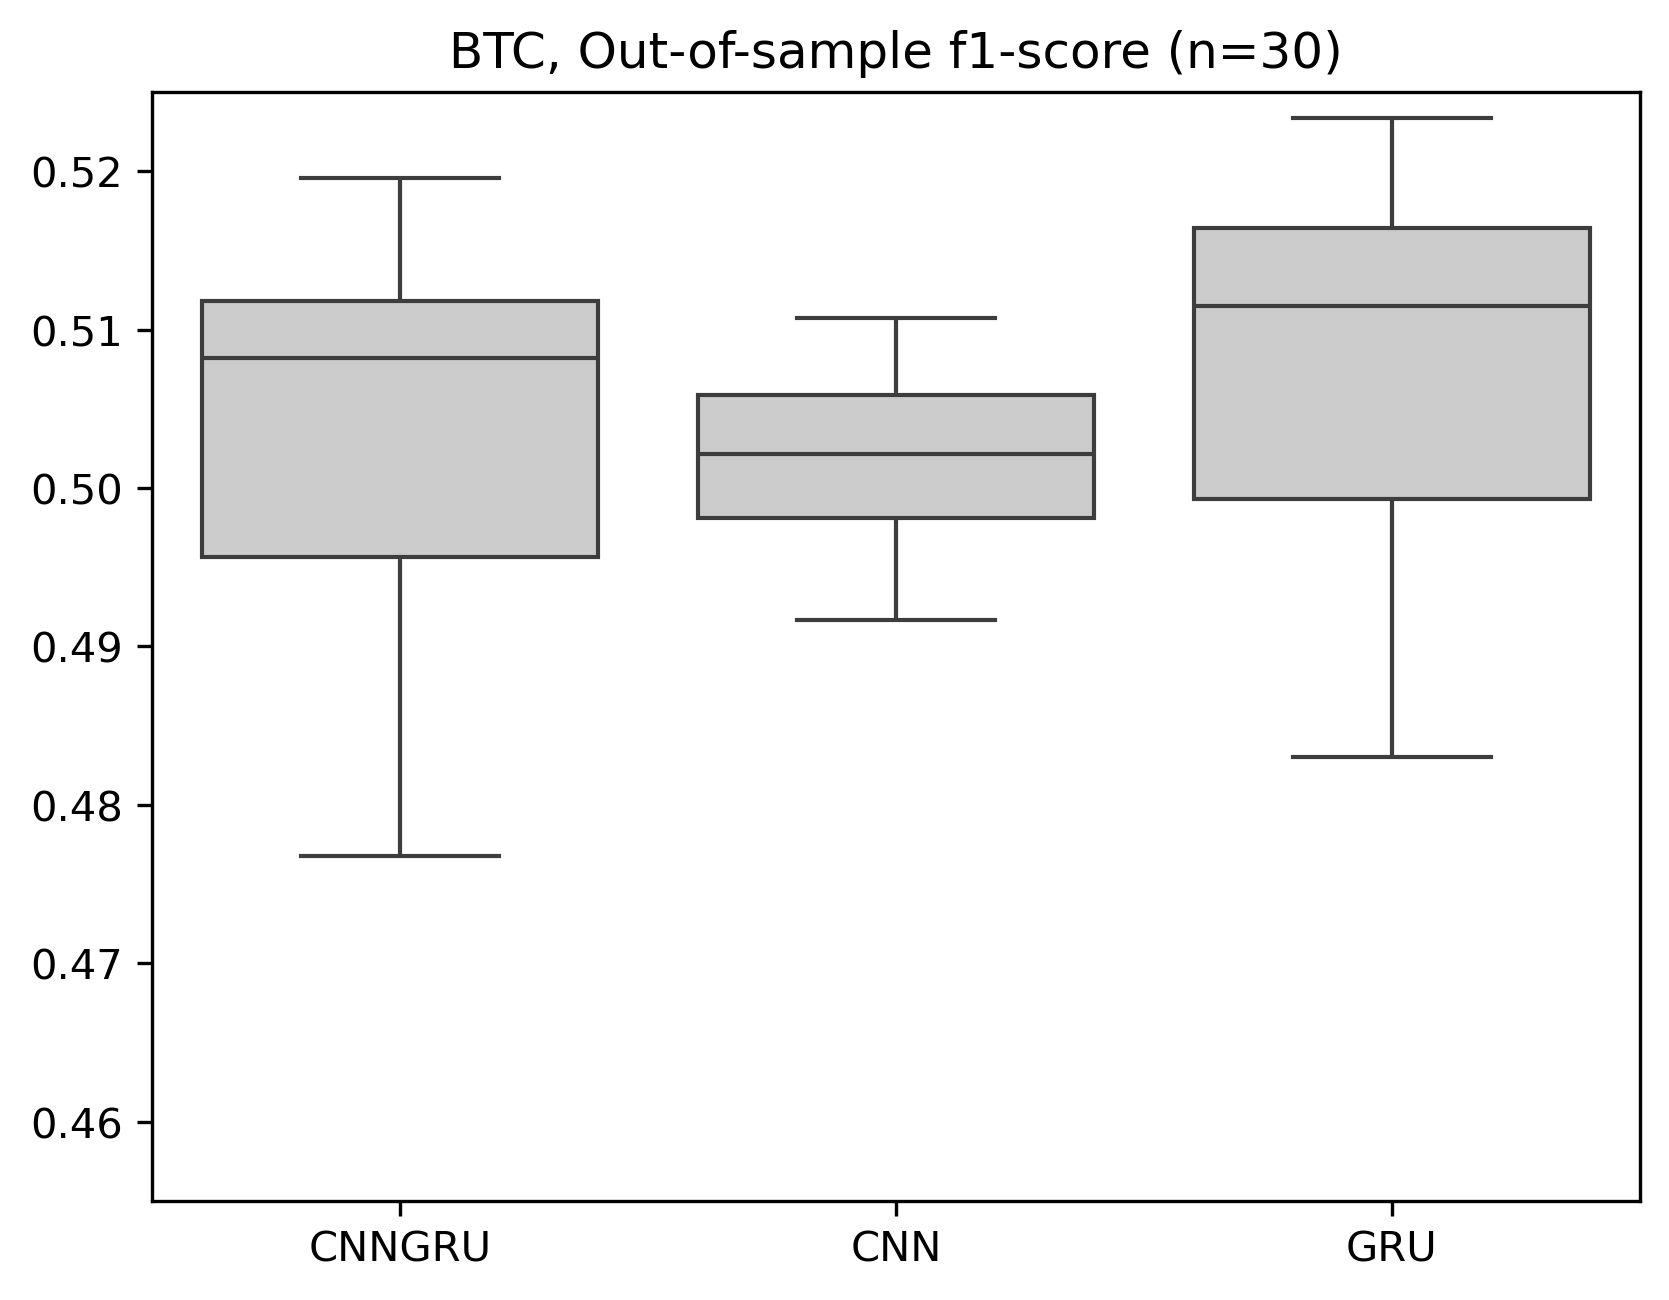

In [25]:
plt.figure(dpi=300)
sns.boxplot(btc_df_f1_score, color=".8")
plt.ylim(0.455, 0.525)
plt.title("BTC, Out-of-sample f1-score (n=30)")
plt.savefig("oos_f1_btc.png")
plt.show()

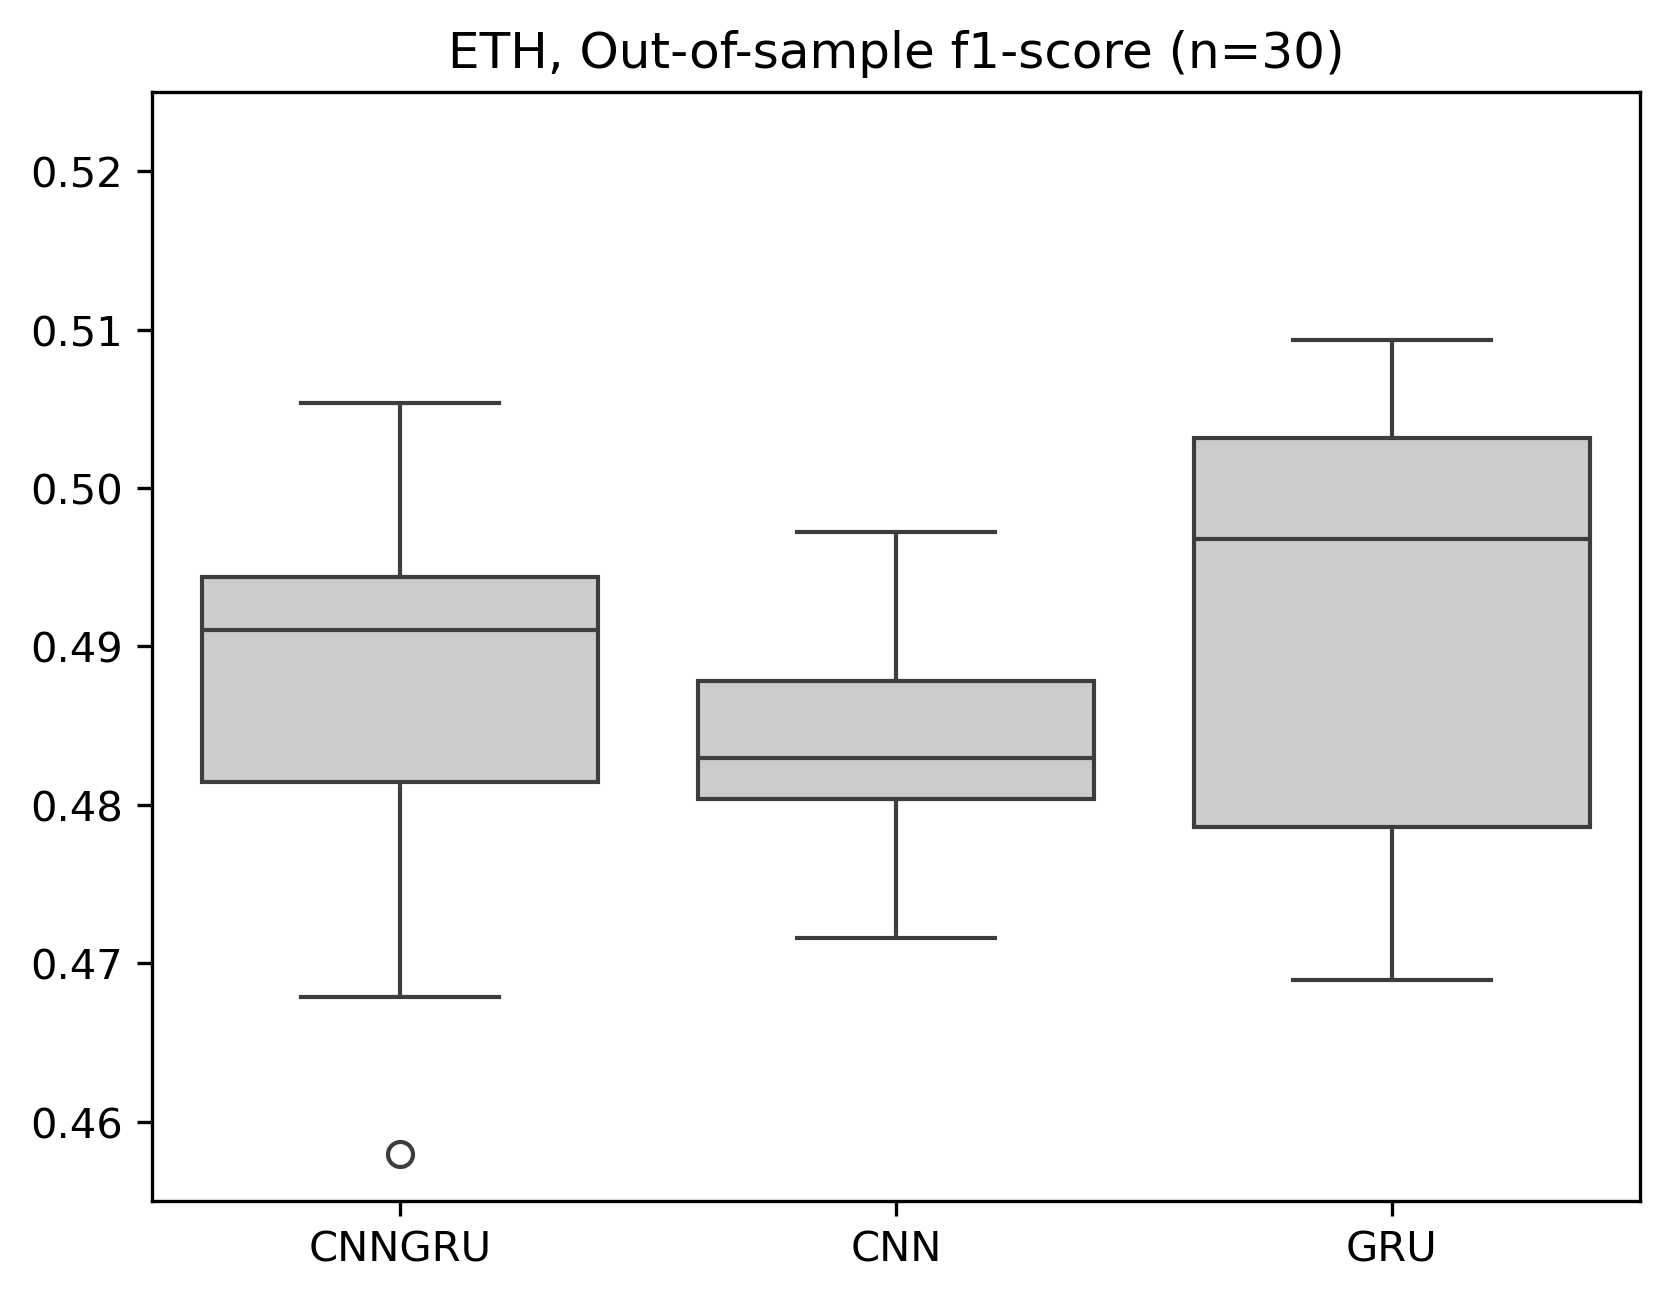

In [26]:
plt.figure(dpi=300)
sns.boxplot(eth_df_f1_score, color=".8")
plt.ylim(0.455, 0.525)
plt.title("ETH, Out-of-sample f1-score (n=30)")
plt.savefig("oos_f1_eth.png")
plt.show()

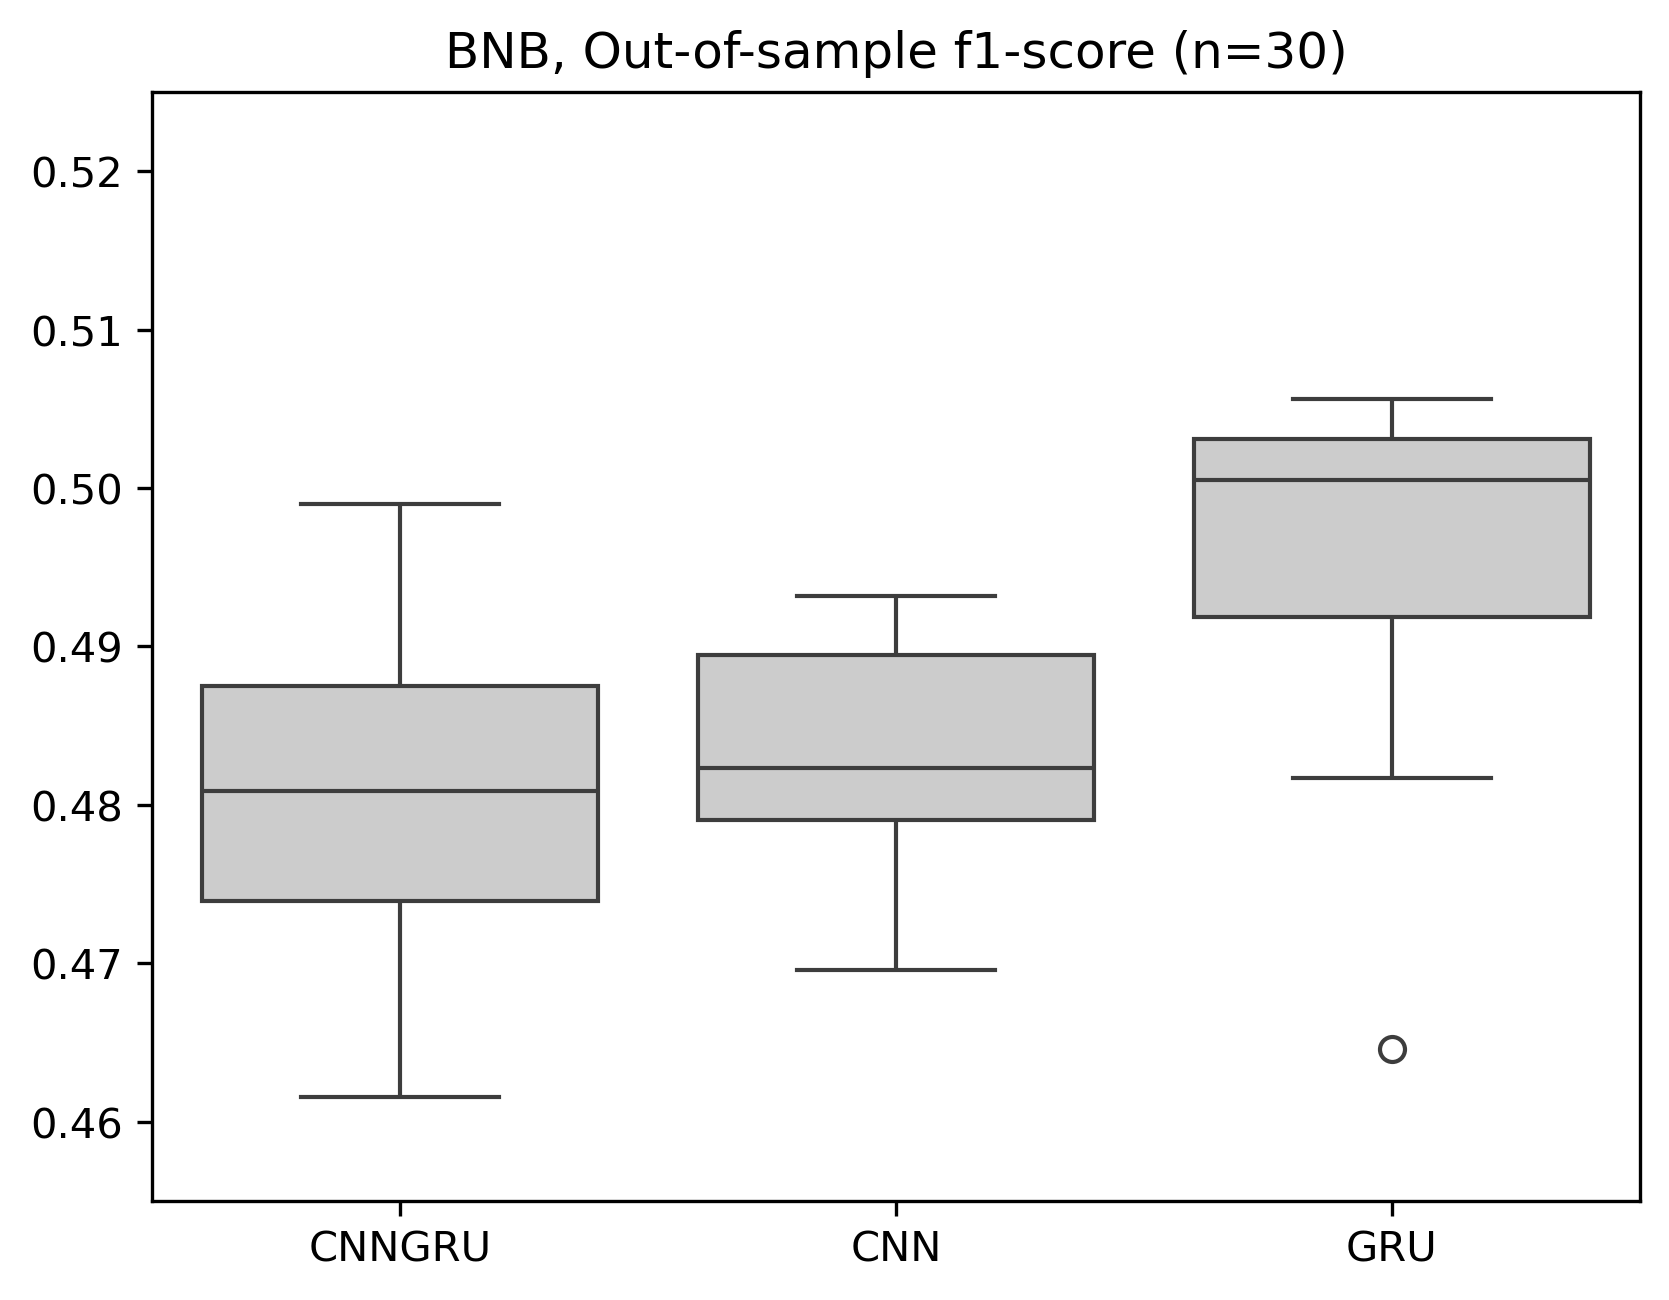

In [27]:
plt.figure(dpi=300)
sns.boxplot(bnb_df_f1_score, color=".8")
plt.ylim(0.455, 0.525)
plt.title("BNB, Out-of-sample f1-score (n=30)")
plt.savefig("oos_f1_bnb.png")
plt.show()

## Recall scores

`plt.ylim(0.775, 0.835)`

In [28]:
btc_df_recall = pd.DataFrame({"CNNGRU": BTC_CNNGRU_test_recall, "CNN": BTC_CNN_test_recall, "GRU": BTC_GRU_test_recall})

In [29]:
eth_df_recall = pd.DataFrame({"CNNGRU": ETH_CNNGRU_test_recall, "CNN": ETH_CNN_test_recall, "GRU": ETH_GRU_test_recall})

In [30]:
bnb_df_recall = pd.DataFrame({"CNNGRU": BNB_CNNGRU_test_recall, "CNN": BNB_CNN_test_recall, "GRU": BNB_GRU_test_recall})

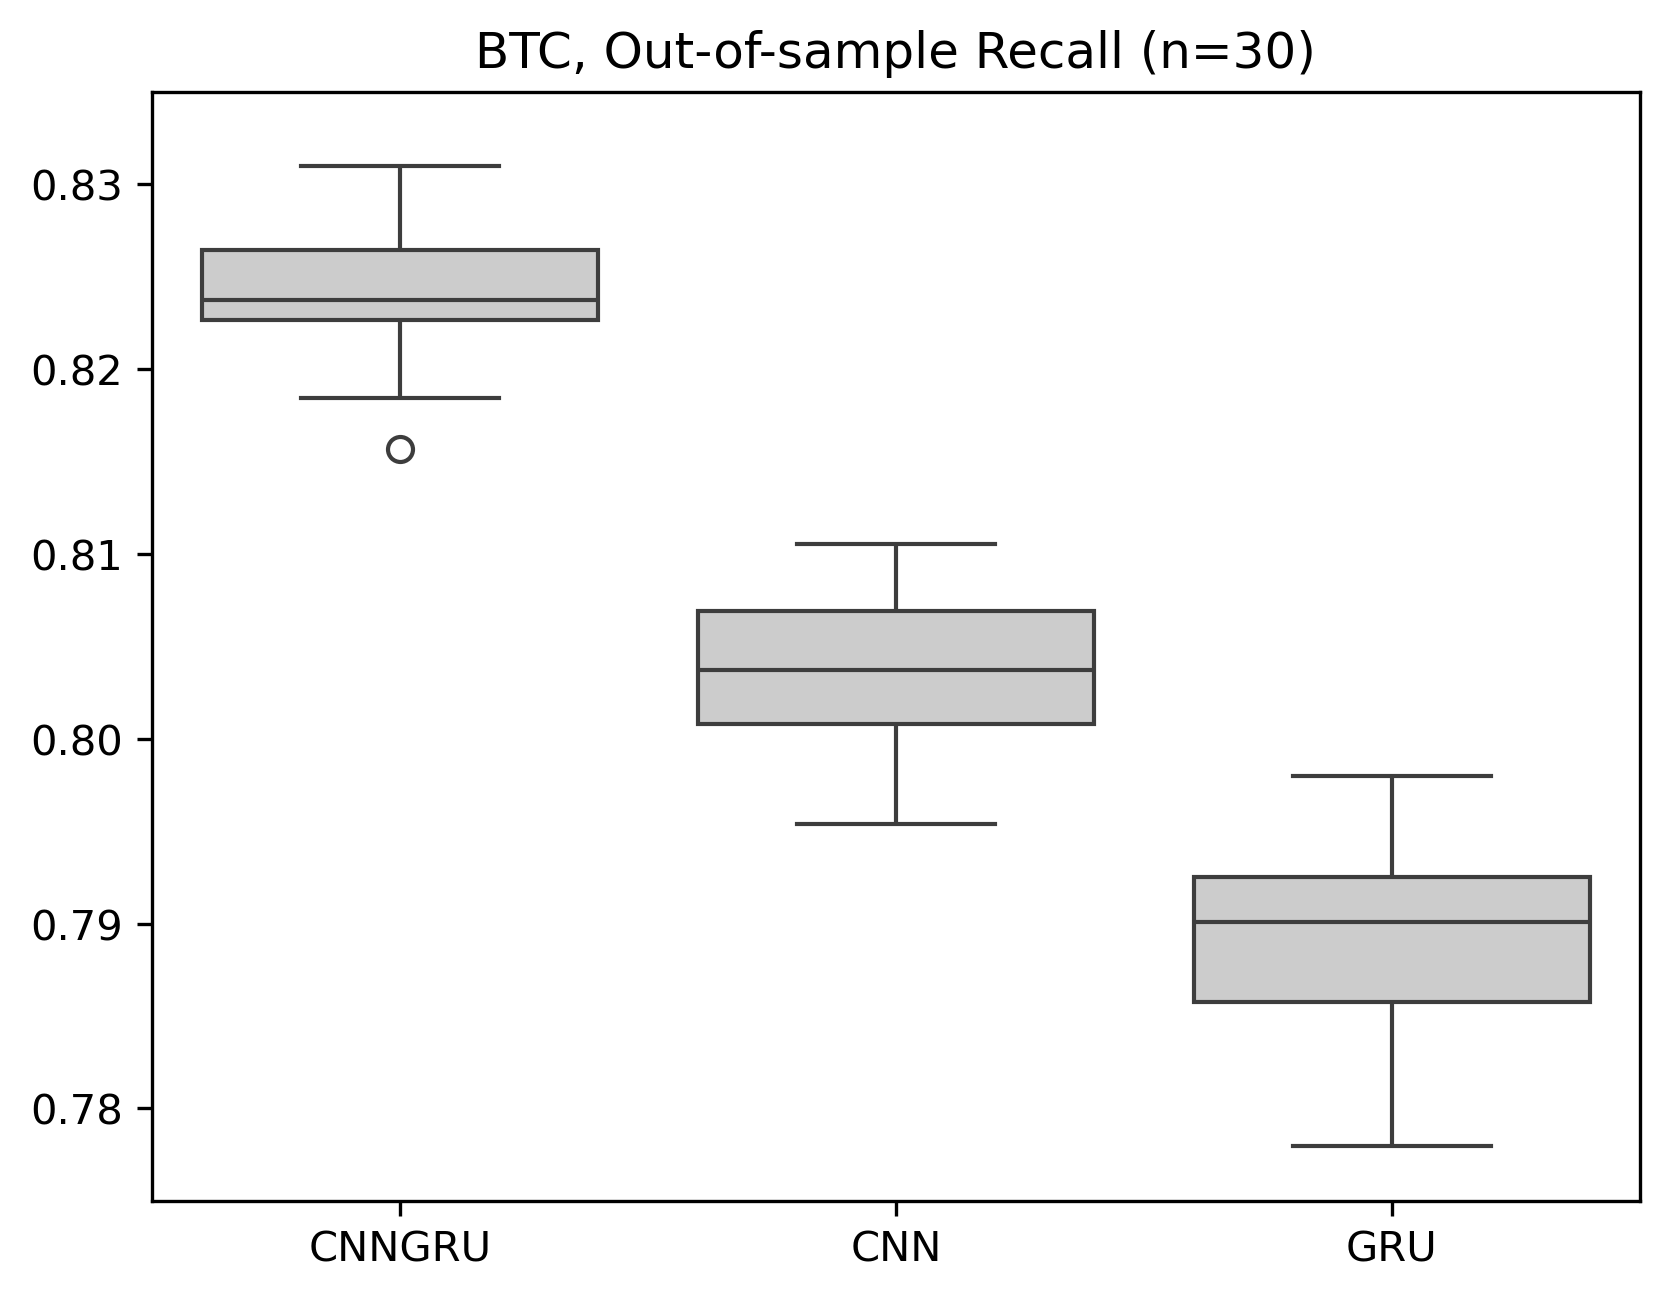

In [31]:
plt.figure(dpi=300)
sns.boxplot(btc_df_recall, color=".8")
plt.ylim(0.775, 0.835)
plt.title("BTC, Out-of-sample Recall (n=30)")
plt.savefig("oos_recall_btc.png")
plt.show()

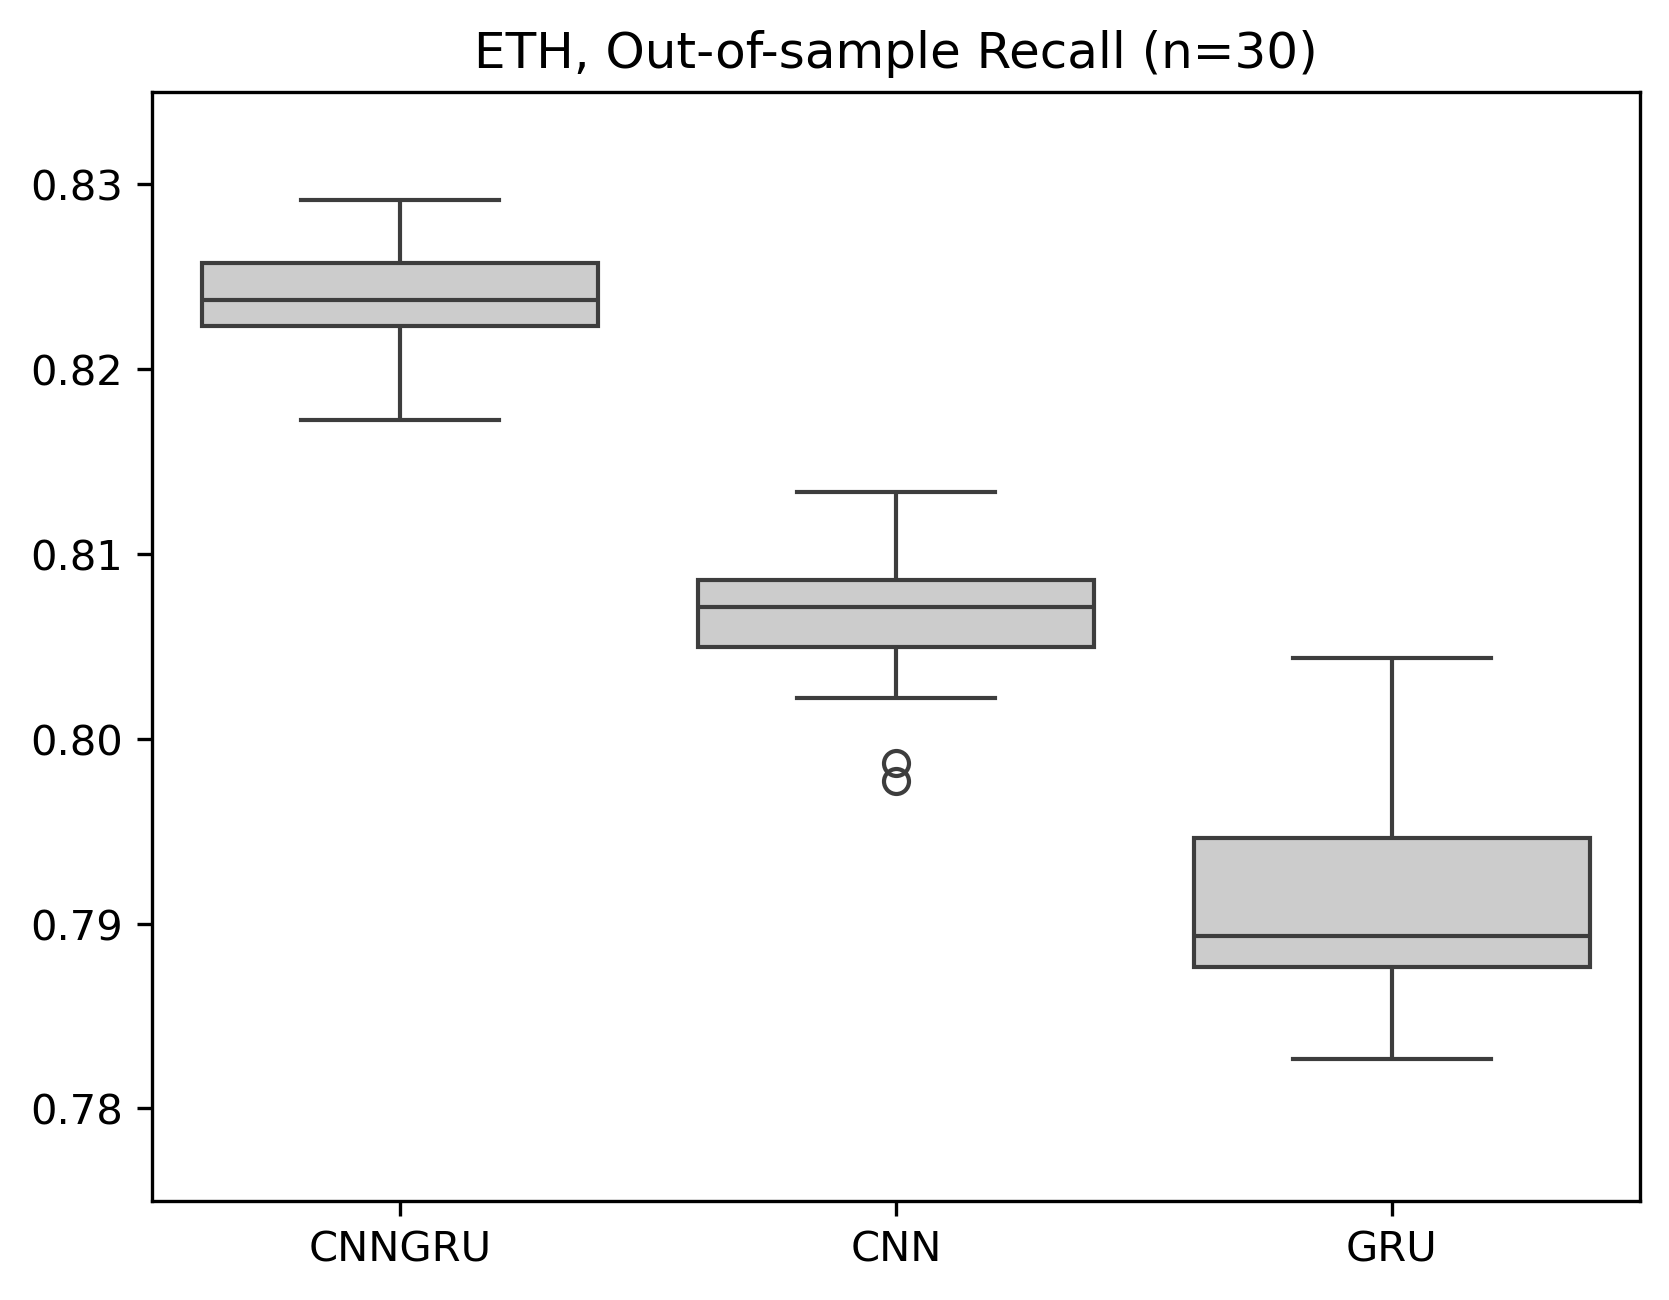

In [32]:
plt.figure(dpi=300)
sns.boxplot(eth_df_recall, color=".8")
plt.ylim(0.775, 0.835)
plt.title("ETH, Out-of-sample Recall (n=30)")
plt.savefig("oos_recall_eth.png")
plt.show()

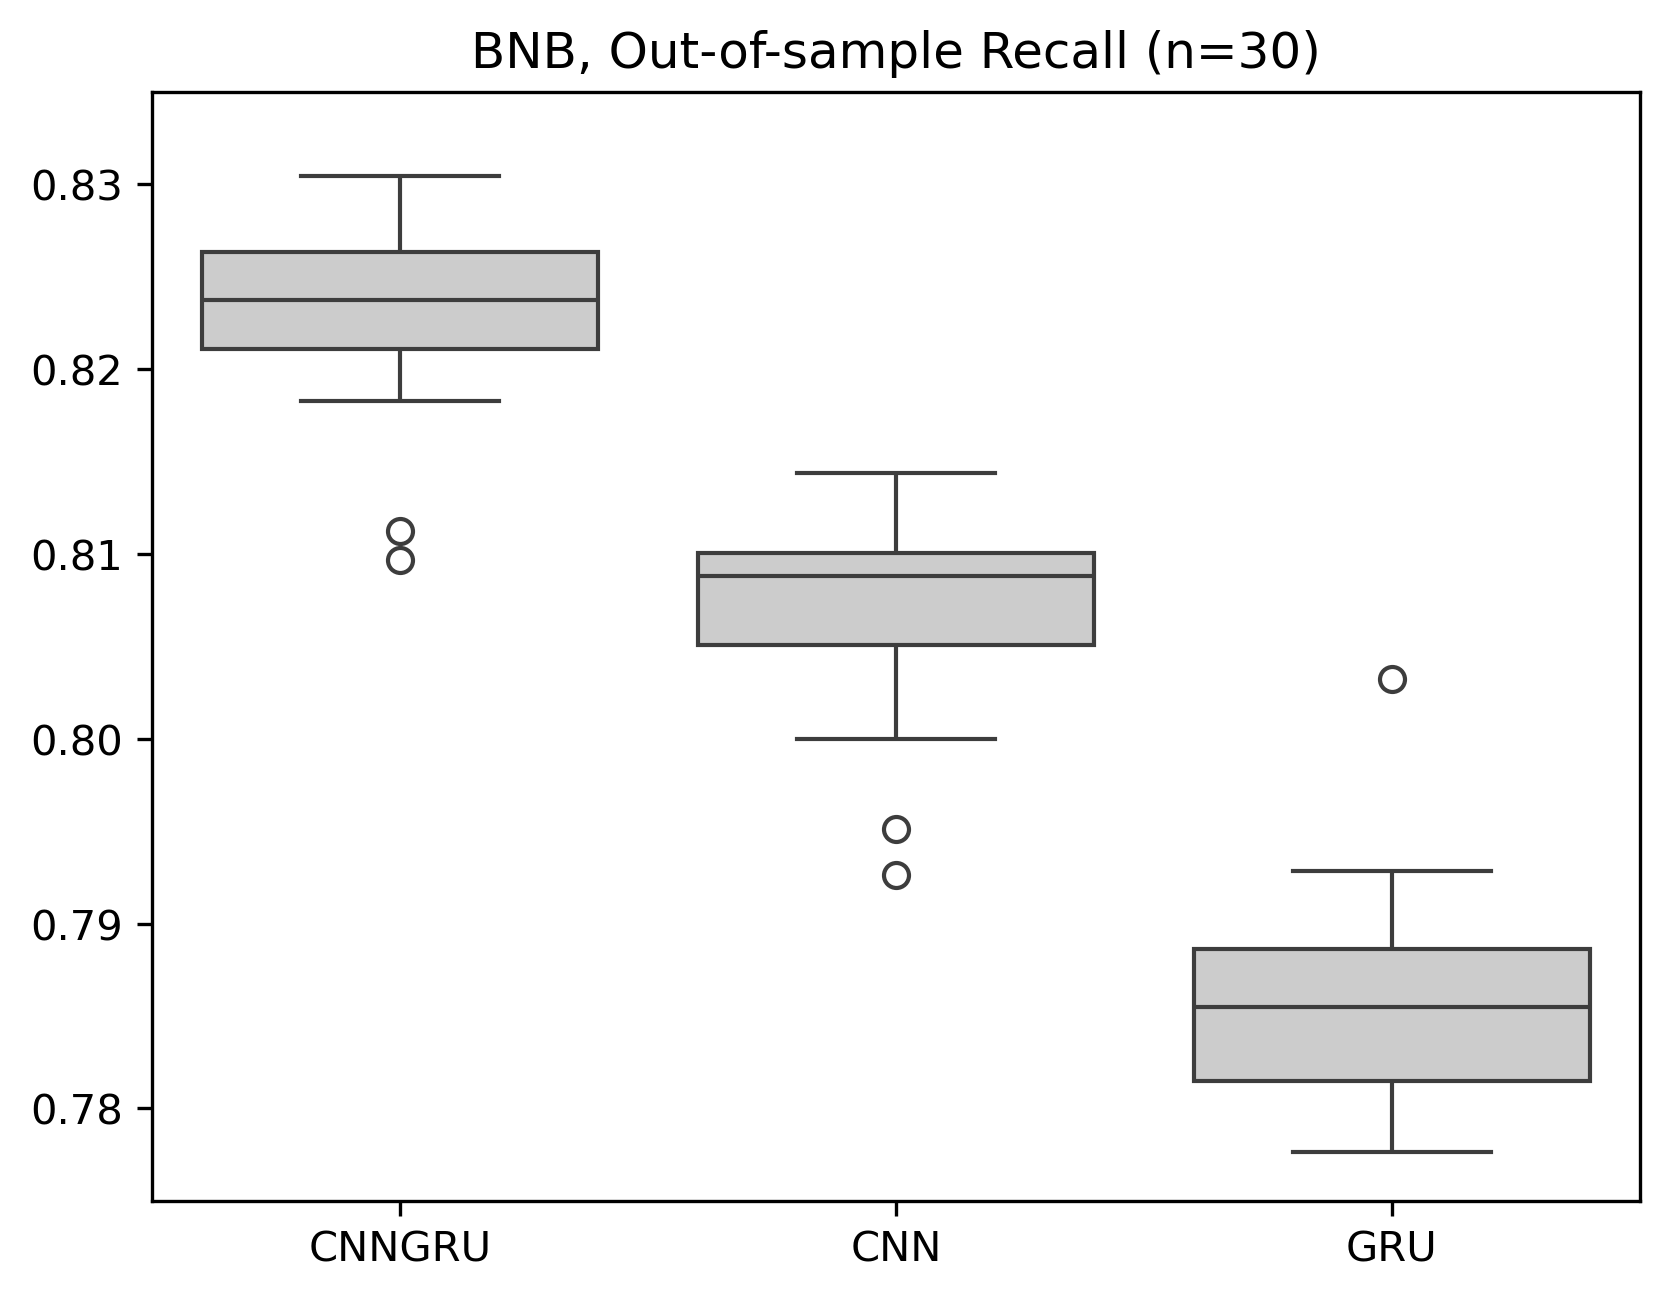

In [33]:
plt.figure(dpi=300)
sns.boxplot(bnb_df_recall, color=".8")
plt.ylim(0.775, 0.835)
plt.title("BNB, Out-of-sample Recall (n=30)")
plt.savefig("oos_recall_bnb.png")
plt.show()

## Precision scores

`plt.ylim(0.465, 0.497)`

In [34]:
btc_df_precision = pd.DataFrame({"CNNGRU": BTC_CNNGRU_test_precision, "CNN": BTC_CNN_test_precision, "GRU": BTC_GRU_test_precision})

In [35]:
eth_df_precision = pd.DataFrame({"CNNGRU": ETH_CNNGRU_test_precision, "CNN": ETH_CNN_test_precision, "GRU": ETH_GRU_test_precision})

In [36]:
bnb_df_precision = pd.DataFrame({"CNNGRU": BNB_CNNGRU_test_precision, "CNN": BNB_CNN_test_precision, "GRU": BNB_GRU_test_precision})

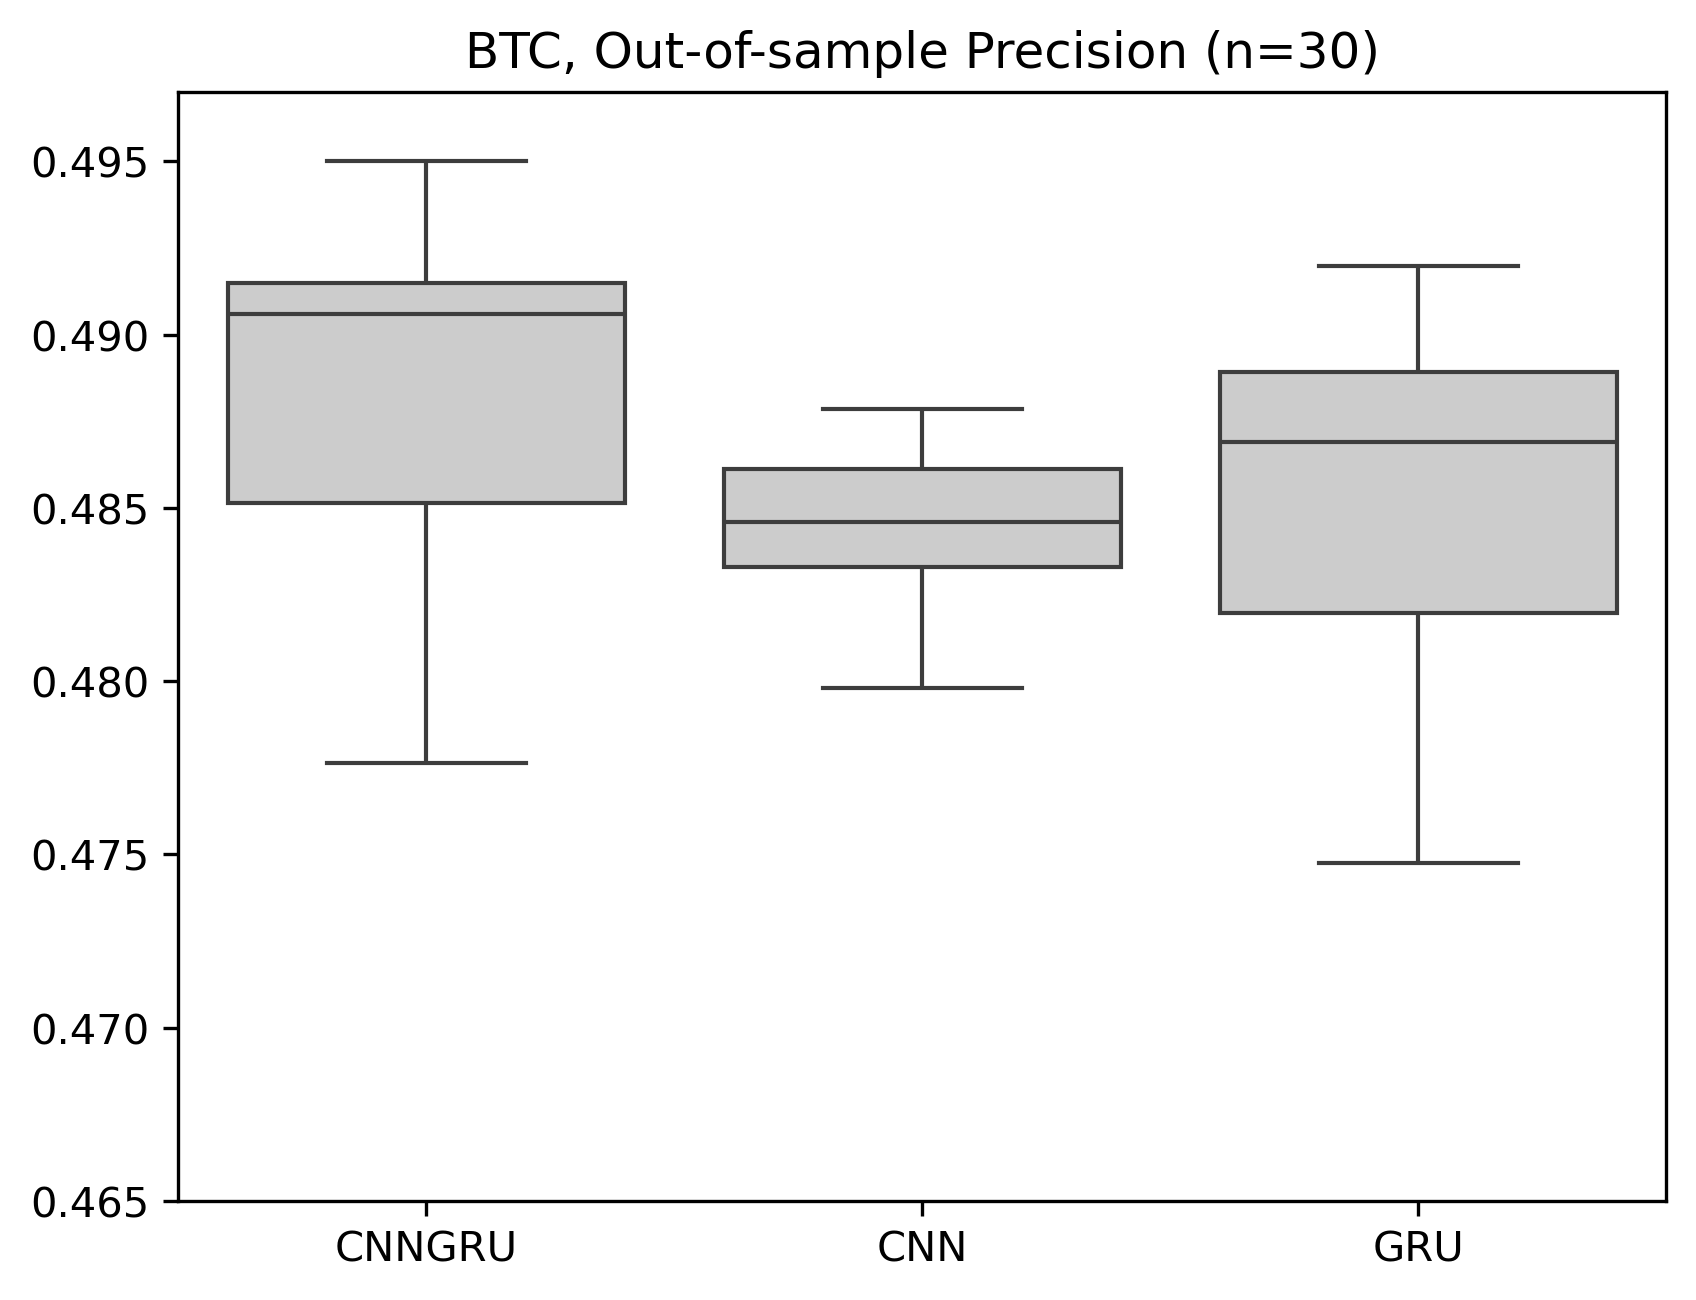

In [37]:
plt.figure(dpi=300)
sns.boxplot(btc_df_precision, color=".8")
plt.ylim(.465, 0.497)
plt.title("BTC, Out-of-sample Precision (n=30)")
plt.savefig("oos_precision_btc.png")
plt.show()

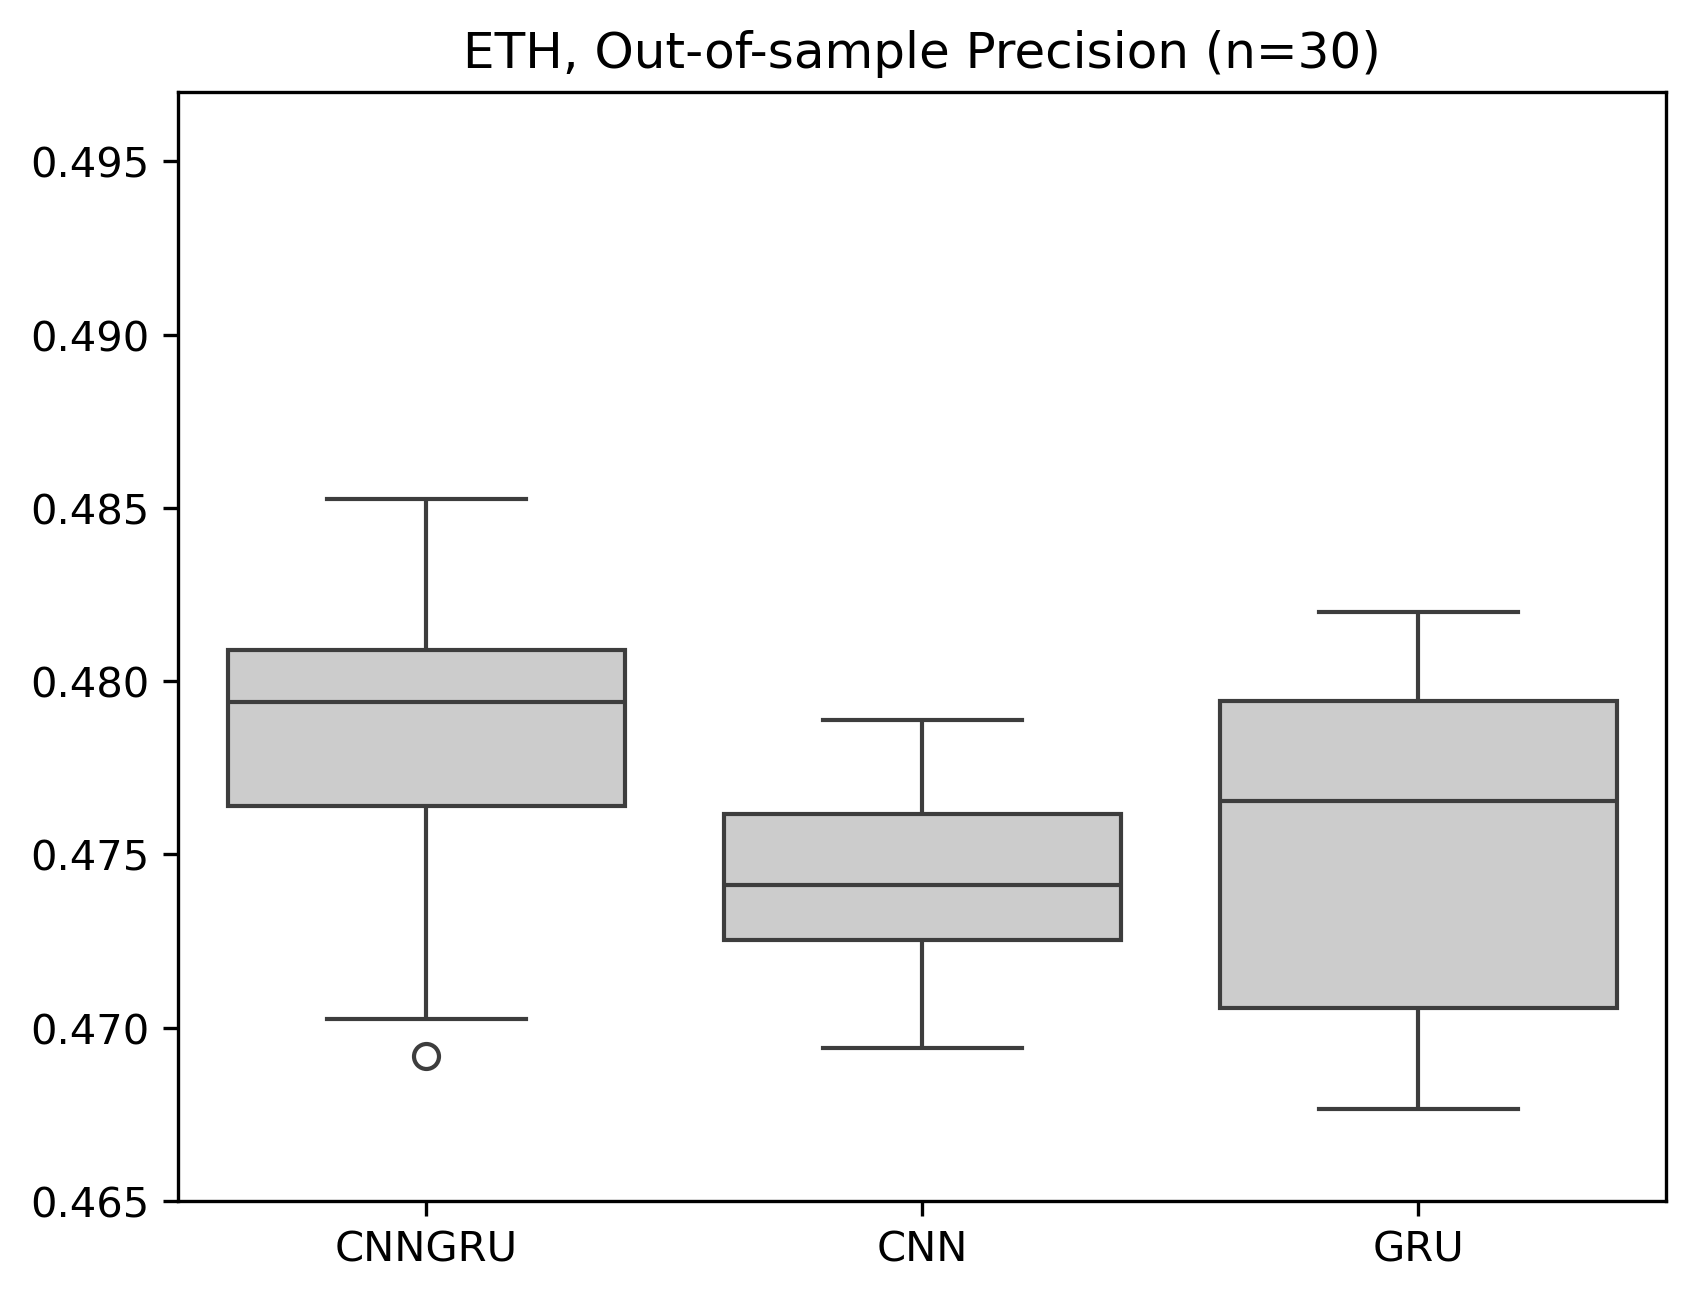

In [38]:
plt.figure(dpi=300)
sns.boxplot(eth_df_precision, color=".8")
plt.ylim(0.465, 0.497)
plt.title("ETH, Out-of-sample Precision (n=30)")
plt.savefig("oos_precision_eth.png")
plt.show()

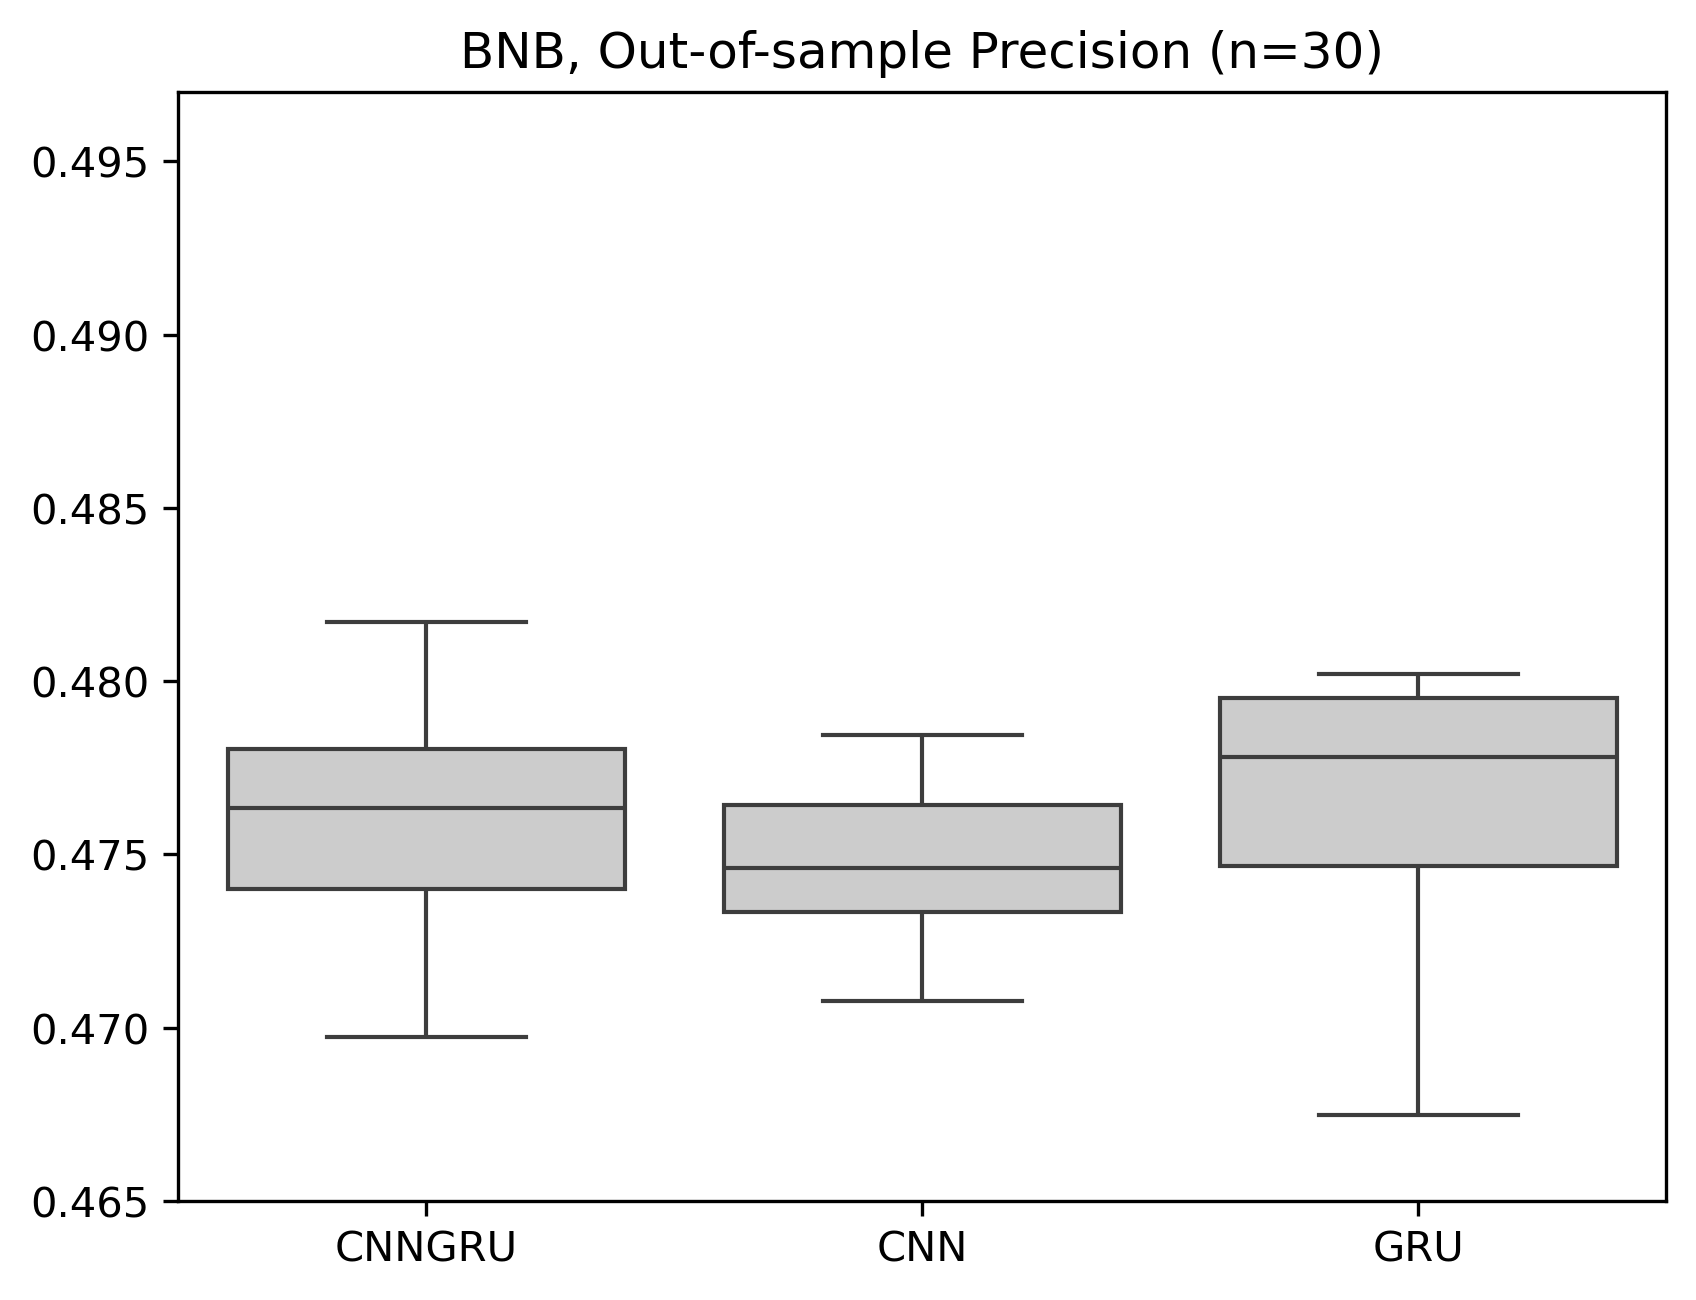

In [39]:
plt.figure(dpi=300)
sns.boxplot(bnb_df_precision, color=".8")
plt.ylim(0.465, 0.497)
plt.title("BNB, Out-of-sample Precision (n=30)")
plt.savefig("oos_precision_bnb.png")
plt.show()

# Median Models

In [40]:
def get_median_model_index(score_list:list):
    list_len = len(score_list)
    return score_list.index(sorted(score_list)[list_len//2])

In [41]:
def generate_preds(df_test, model_name, test_preds, timeperiod=30):
    df = df_test.copy()
    df[f"signal_pred_{model_name}"] = np.nan
    df["buy_hold"] = np.nan
    df.loc[df.iloc[timeperiod-1].name:df.iloc[-1].name, f"signal_pred_{model_name}"] = test_preds
    df.loc[df.iloc[timeperiod-1].name, "buy_hold"] = 1
    df.loc[df.iloc[len(df)-2].name, "buy_hold"] = 2
    return df

## BTC, CNN-GRU

In [43]:
BTC_CNNGRU_exec = ExecutionHandler(dataset=btc, model=CNNGRU,
                                   model_id=f"BTC",
                                   device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, 
                                   test_end_idx=len(btc),
                                   checkpoints_path='./checkpoints-profit-test',
                                   preload_weights_path="CNNGRU-BTC.pt",
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
# BTC_CNNGRU_exec.execute_training_validation()
# BTC_CNNGRU_exec.execute_testing()

In [44]:
BTC_CNNGRU_exec.execute_testing()

IndexError: list index out of range

## BTC, CNN

In [ ]:
BTC_CNN_exec = ExecutionHandler(dataset=btc, model=CNN,
                                model_id=f"BTC",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(btc),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BTC_CNN_exec.execute_training_validation()
BTC_CNN_exec.execute_testing()

In [ ]:
BTC_CNN_test_df = generate_preds(BTC_CNN_exec.loader_gen.test_df, 
                                 BTC_CNN_exec.model_trainer.test_pred_y.numpy())

## BTC, GRU

In [ ]:
BTC_GRU_exec = ExecutionHandler(dataset=btc, model=GRU,
                                model_id=f"BTC",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(btc),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BTC_GRU_exec.execute_training_validation()
BTC_GRU_exec.execute_testing()

In [ ]:
BTC_GRU_test_df = generate_preds(BTC_GRU_exec.loader_gen.test_df, 
                                 BTC_GRU_exec.model_trainer.test_pred_y.numpy())

## ETH, CNN-GRU

In [ ]:
ETH_CNNGRU_exec = ExecutionHandler(dataset=eth, model=CNNGRU,
                                   model_id=f"ETH",
                                   device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, 
                                   test_end_idx=len(eth),
                                   checkpoints_path='./checkpoints-profit-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
ETH_CNNGRU_exec.execute_training_validation()
ETH_CNNGRU_exec.execute_testing()

In [ ]:
ETH_CNNGRU_test_df = generate_preds(ETH_CNNGRU_exec.loader_gen.test_df, 
                                    ETH_CNNGRU_exec.model_trainer.test_pred_y.numpy())

## ETH, CNN

In [ ]:
ETH_CNN_exec = ExecutionHandler(dataset=eth, model=CNN,
                                model_id=f"ETH",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(eth),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
ETH_CNN_exec.execute_training_validation()
ETH_CNN_exec.execute_testing()

In [ ]:
ETH_CNN_test_df = generate_preds(ETH_CNN_exec.loader_gen.test_df, 
                                 ETH_CNN_exec.model_trainer.test_pred_y.numpy())

## ETH, GRU

In [ ]:
ETH_GRU_exec = ExecutionHandler(dataset=eth, model=GRU,
                                model_id=f"ETH",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(eth),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
ETH_GRU_exec.execute_training_validation()
ETH_GRU_exec.execute_testing()

In [ ]:
ETH_GRU_test_df = generate_preds(ETH_GRU_exec.loader_gen.test_df, 
                                 ETH_GRU_exec.model_trainer.test_pred_y.numpy())

## BNB, CNN-GRU

In [ ]:
BNB_CNNGRU_exec = ExecutionHandler(dataset=bnb, model=CNNGRU,
                                   model_id=f"BNB",
                                   device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, 
                                   test_end_idx=len(bnb),
                                   checkpoints_path='./checkpoints-profit-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BNB_CNNGRU_exec.execute_training_validation()
BNB_CNNGRU_exec.execute_testing()

In [ ]:
BNB_CNNGRU_test_df = generate_preds(BNB_CNNGRU_exec.loader_gen.test_df, 
                                    BNB_CNNGRU_exec.model_trainer.test_pred_y.numpy())

## BNB, CNN

In [ ]:
BNB_CNN_exec = ExecutionHandler(dataset=bnb, model=CNN,
                                model_id=f"BNB",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(bnb),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BNB_CNN_exec.execute_training_validation()
BNB_CNN_exec.execute_testing()

In [ ]:
BNB_CNN_test_df = generate_preds(BNB_CNN_exec.loader_gen.test_df, 
                                 BNB_CNN_exec.model_trainer.test_pred_y.numpy())

## BNB, GRU

In [ ]:
BNB_GRU_exec = ExecutionHandler(dataset=bnb, model=GRU,
                                model_id=f"BNB",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(bnb),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BNB_GRU_exec.execute_training_validation()
BNB_GRU_exec.execute_testing()

In [ ]:
BNB_GRU_test_df = generate_preds(BNB_GRU_exec.loader_gen.test_df, 
                                 BNB_GRU_exec.model_trainer.test_pred_y.numpy())

# Profitability analysis

In [ ]:
class SimulatedTradingSession:
    def __init__(self, df:pd.DataFrame, model_name: str, ticker: str, 
                 starting_capital:float=10000.0, 
                 fee_size:float=0.001, stake_size:float=1.0,
                 signal="signal_pred"):
        self.df = df.copy()
        self.model_name = model_name
        self.ticker = ticker
        self.starting_balance = starting_capital
        self.current_balance = starting_capital
        self.capital = starting_capital
        self.fee_size = fee_size
        self.stake_size = stake_size
        self.signal = signal
        self.in_market = False
        self.current_coin_quantity = 0.00000000
        self.order_history = {}
        self.df[f"balance_cumulative_{self.model_name}"] = starting_capital
        
    def backtest(self):
        """
        Backtest assumes that the model will buy at a fixed
        stake according to the stake size, then sell everything.
        """
        print(f"Starting backtest on {self.ticker}...")
        print(f"Opening balance: {self.capital:.2f}")
        starting_idx = self.df.index[0]
        ending_idx = self.df.index[-1]
        for i in range(starting_idx+1, ending_idx+1):
            if not self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 1:
                # Declare the $ stake at the current step, ready to buy
                stake_buy = self.stake_size * self.capital
                # Calculate the fee for this buy trade
                trading_fee_buy = self.fee_size * stake_buy
                # Calculate the post-fee stake for each trade
                stake_buy_post_fee = stake_buy - trading_fee_buy
                # Calculate the quantity that will be purchased for the post-fee stake
                quantity_buy_post_fee = stake_buy_post_fee / self.df.loc[i-1]['close']
                # TRANSACTION COMPLETE: Update the current capital buy subtracting the total stake
                self.capital -= stake_buy
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity += quantity_buy_post_fee
                # The model is now in the market
                self.in_market = True
                # Report new account balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append stats to order history
                self.order_history[len(self.order_history)+1] = {
                    'ticker': self.ticker,
                    'date_open': self.df.loc[i]['date'],
                    'quantity_open': round(quantity_buy_post_fee, 8),
                    'price_open': round(self.df.loc[i-1]['close'], 2),
                    'date_close': None,
                    'quantity_close': None,
                    'price_close': None,
                    'fee_open': round(trading_fee_buy, 2),
                    'fee_close': None,
                    'fee_total': round(trading_fee_buy, 2),
                    'closed': False,
                    'pnl': None
                }
                # Print stats: 
#                 print(f"ENTER:\t{self.current_coin_quantity:.8f} {self.ticker} @ {self.df.loc[i-1]['close']:.2f}\tFEE: {-trading_fee_buy:.2f}\tBALANCE: {self.current_balance:.2f}")
            
            elif self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 2:
                # Declare the $ stake at the current step, ready to sell
                quantity_sell = self.current_coin_quantity
                stake_sell = quantity_sell * self.df.loc[i-1]['close']
                # Calculate the fee for this sell trade
                trading_fee_sell = self.fee_size * stake_sell
                # TRANSACTION COMPLETE: Add back the capital minus trading fee
                self.capital += (stake_sell - trading_fee_sell)
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity -= quantity_sell
                # The model is now out of the market
                self.in_market = False
                # Update current balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append new stats to the current order
                orderid = len(self.order_history)
                self.order_history[orderid]['closed'] = True
                self.order_history[orderid]['date_close'] = self.df.loc[i]['date']
                self.order_history[orderid]['quantity_close'] = quantity_sell
                self.order_history[orderid]['price_close'] = round(self.df.loc[i-1]['close'], 2)
                self.order_history[orderid]['fee_close'] = trading_fee_sell
                self.order_history[orderid]['fee_total'] += self.order_history[orderid]['fee_close']
                self.order_history[orderid]['pnl'] = \
                    (self.order_history[orderid]['price_close'] * self.order_history[orderid]['quantity_close']) - \
                    (self.order_history[orderid]['price_open'] * self.order_history[orderid]['quantity_open']) - \
                    self.order_history[orderid]['fee_total']
                
                # Print stats: 
#                 print(f"EXIT:\t{quantity_sell:.8f} {self.ticker} @ {self.df.loc[i-1]['close']:.2f}\tFEE: {-trading_fee_sell:.2f}\tBALANCE: {self.current_balance:.2f}\tPNL: {self.order_history[orderid]['pnl']:.2f}")
            # Update current balance
            self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
            # Update the cumulative balance
            self.df.loc[i, f"balance_cumulative_{self.model_name}"] = self.current_balance
        # Report final value:
        print("==========================================================")
        print(f"Backtest finished.\nClosing balance: {self.current_balance:.2f}, PNL: {self.current_balance-self.starting_balance:.2f}")
        if self.in_market:
            last_orderid = len(self.order_history)
            print(f"Open order: {self.order_history[last_orderid]}")
            
    def get_cumulative_returns(self):
        portfolio_returns = self.df[f"balance_cumulative_{self.model_name}"].pct_change()[1:]
        self.df[f"{self.model_name}"] = np.cumprod(portfolio_returns + 1)
        return
        

## Profitability: BTC dataset

In [ ]:
BTC_test_df = generate_preds(df_test=BTC_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=BTC_CNNGRU_exec.model_trainer.test_pred_y.numpy())

BTC_test_df = generate_preds(df_test=BTC_test_df, 
                             model_name='CNN',
                             test_preds=BTC_CNN_exec.model_trainer.test_pred_y.numpy())

BTC_test_df = generate_preds(df_test=BTC_test_df, 
                             model_name='GRU',
                             test_preds=BTC_GRU_exec.model_trainer.test_pred_y.numpy())

In [ ]:
BTC_simulator = SimulatedTradingSession(df=BTC_test_df, model_name="CNNGRU", ticker="BTC", stake_size=1.0, signal="signal_pred")
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()

BTC_simulator = SimulatedTradingSession(df=BTC_simulator.df, model_name="CNN", ticker="BTC", stake_size=1.0, signal="signal_pred")
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()

BTC_simulator = SimulatedTradingSession(df=BTC_simulator.df, model_name="GRU", ticker="BTC", stake_size=1.0, signal="signal_pred")
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()


In [ ]:
BTC_cum_rets_df = BTC_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
BTC_cum_rets_df = BTC_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

In [ ]:
sns.lineplot(data=BTC_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("BTC, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")

plt.show()

## Profitability: ETH dataset

In [ ]:
ETH_test_df = generate_preds(df_test=ETH_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=ETH_CNNGRU_exec.model_trainer.test_pred_y.numpy())

ETH_test_df = generate_preds(df_test=ETH_test_df, 
                             model_name='CNN',
                             test_preds=ETH_CNN_exec.model_trainer.test_pred_y.numpy())

ETH_test_df = generate_preds(df_test=ETH_test_df, 
                             model_name='GRU',
                             test_preds=ETH_GRU_exec.model_trainer.test_pred_y.numpy())

In [ ]:
ETH_simulator = SimulatedTradingSession(df=ETH_test_df, model_name="CNNGRU", ticker="ETH", stake_size=1.0, signal="signal_pred")
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="CNN", ticker="ETH", stake_size=1.0, signal="signal_pred")
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="GRU", ticker="ETH", stake_size=1.0, signal="signal_pred")
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()


In [ ]:
ETH_cum_rets_df = ETH_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
ETH_cum_rets_df = ETH_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

In [ ]:
sns.lineplot(data=ETH_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("ETH, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
plt.show()

## Profitability: BNB dataset

In [ ]:
BNB_test_df = generate_preds(df_test=BNB_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=BNB_CNNGRU_exec.model_trainer.test_pred_y.numpy())

BNB_test_df = generate_preds(df_test=BNB_test_df, 
                             model_name='CNN',
                             test_preds=BNB_CNN_exec.model_trainer.test_pred_y.numpy())

BNB_test_df = generate_preds(df_test=BNB_test_df, 
                             model_name='GRU',
                             test_preds=BNB_GRU_exec.model_trainer.test_pred_y.numpy())

In [ ]:
BNB_simulator = SimulatedTradingSession(df=BNB_test_df, model_name="CNNGRU", ticker="BNB", stake_size=1.0, signal="signal_pred")
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

BNB_simulator = SimulatedTradingSession(df=BNB_simulator.df, model_name="CNN", ticker="BNB", stake_size=1.0, signal="signal_pred")
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

BNB_simulator = SimulatedTradingSession(df=BNB_simulator.df, model_name="GRU", ticker="BNB", stake_size=1.0, signal="signal_pred")
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()


In [ ]:
BNB_cum_rets_df = BNB_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
BNB_cum_rets_df = BNB_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

In [ ]:
sns.lineplot(data=BNB_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("BNB, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
plt.show()